#### This file contains the minimal code for the Proof Of Concept Demonstration of MJOP Net and AVAM Net. 
#### Note that for running MJOP Net code, access to Loihi is required. AVAM Net code can be run on CPU/GPU, and Loihi.

In [1]:
import matplotlib.pyplot as plt
import nengo
import nengo_dl
import numpy as np
import collections
import pickle
import nengo_loihi

# MJOP Net Creation

In [2]:
def configure_ensemble_for_2x2_max_join_op(loihi_sim, ens):
  """
  Configures a Nengo Ensemble to create multiple Multi-Compartment Neurons with 
  4 compartments and MAX join-Op between those compartments.
  
  Args:
    loihi_sim <nengo_loihi.simulator.Simulator>: NengoLoihi simulator object.
    ens <nengo.ensemble.Ensemble>: The Ensemble whose neurons are supposed to be 
                                   configured.
  """
  
  nxsdk_board = loihi_sim.sims["loihi"].nxsdk_board
  board = loihi_sim.sims["loihi"].board

  # Get the blocks (which can be many depending on how large the Ensemble `ens`
  # is and in how many blocks is it broken).
  blocks = loihi_sim.model.objs[ens]
  #print("Number of (in and out) Blocks for Ensemble %s are: %s and %s."
  #          % (ens, len(blocks["in"]), len(blocks["out"])))
  for block in blocks["in"]:
    in_chip_idx, in_core_idx, in_block_idx, in_compartment_idxs, _ = (
        board.find_block(block))
    nxsdk_core = nxsdk_board.n2Chips[in_chip_idx].n2CoresAsList[in_core_idx]

    # Set the cxProfileCfg[0] as the leaf node's profile with `stackOut=3` =>
    # it pushes the current U to the top of the stack.
    nxsdk_core.cxProfileCfg[0].configure(stackOut=3, bapAction=0, refractDelay=0)
    # Set the cxProfileCfg[1] as the intermediate node's profile with `stackIn=2`
    # => it pops the element from the stack, `joinOp=2` => it does the MAX joinOp
    # with the popped element from stack and its current U, `stackOut=3` => it
    # pushes the MAXed current U on the top of the stack,
    # `decayU=nxsdk_core.cxProfileCfg[0].decayU` => the decay constant for current
    # U is same as that of the cxProfileCfg[0]. If `decayU` is 0, the current due
    # incoming spike never decays resulting in constant spiking of the neuron
    # and if it is default value, then the current decays instantly.
    nxsdk_core.cxProfileCfg[1].configure(
        stackIn=2, joinOp=2, stackOut=3, decayU=nxsdk_core.cxProfileCfg[0].decayU)
    # Set the root node which will output the spikes corresonding to the MAXed U.
    nxsdk_core.cxProfileCfg[2].configure(
        stackIn=2, joinOp=2, decayU=nxsdk_core.cxProfileCfg[0].decayU)

    # Set the compartments now.
    # Since the incoming connection from the previous Conv layer already as the
    # inputs in order of grouped slices, they are simply connected to the neuron
    # in this Ensembel `ens` from 0 index onwards.
    # `in_compartment_idxs` has the mapping of all compartment neurons in a
    # specific core, starting from index 0.

    # Maximum number of compartment idxs = 1024.
    for i in range(0, len(in_compartment_idxs), 4):
      c_idx = in_compartment_idxs[i]
      # Set a leaf node/compartment.
      nxsdk_core.cxCfg[c_idx].configure(cxProfile=0, vthProfile=0)
      # Set two intermediate nodes/compartments.
      nxsdk_core.cxCfg[c_idx+1].configure(cxProfile=1, vthProfile=0)
      nxsdk_core.cxCfg[c_idx+2].configure(cxProfile=1, vthProfile=0)
      # Set a root node/compartment to output spikes corresponding to MAX input.
      nxsdk_core.cxCfg[c_idx+3].configure(cxProfile=2, vthProfile=0)

# AVAM Net Creation

In [3]:
def get_loihi_adapted_avam_net_for_2x2_max_pooling(
    seed=0, max_rate=500, radius=0.5, do_max=True, synapse=None):
  """
  Returns a Loihi adapted network for absolute value based associative max pooling.

  Args:
    seed <int>: Any arbitrary seed value.
    max_rate <int>: Max Firing rate of the neurons.
    radius <int>: Value at which Maximum Firing rate occurs (
                  i.e. the representational radius)
    do_max <bool>: Do MaxPooling if True else do AvgPooling.
    synapse <float>: Synapic time constant.
  """
  with nengo.Network(seed=seed) as net:
    net.inputs = nengo.Node(size_in=4) # 4 dimensional input for 2x2 MaxPooling.

    def _get_ensemble():
      ens =  nengo.Ensemble(
          n_neurons=2, dimensions=1, encoders=[[1], [-1]], intercepts=[0, 0],
          max_rates=[max_rate, max_rate], radius=radius,
          neuron_type=nengo_loihi.neurons.LoihiSpikingRectifiedLinear())
      return ens

    ens_12 = _get_ensemble() # Ensemble for max(a, b).
    ens_34 = _get_ensemble() # Ensemble for max(c, d).
    ens_1234 = _get_ensemble() # Ensemble for max(max(a, b), max(c, d)).

    # Intermediate passthrough nodes for summing and outputting the result.
    node_12 = nengo.Node(size_in=1) # For max(a, b).
    node_34 = nengo.Node(size_in=1) # For max(c, d).
    net.otp_node = nengo.Node(size_in=1) # For max(max(a, b), max(c, d)).
    
    ############################################################################
    # Calculate max(a, b) = (a+b)/2 + |a-b|/2.
    # Calculate (a+b)/2.
    nengo.Connection(net.inputs[0], node_12, synapse=None, transform=1/2)
    nengo.Connection(net.inputs[1], node_12, synapse=None, transform=1/2)
    
    if do_max:
      # Calculate |a-b|/2.
      nengo.Connection(net.inputs[0], ens_12, synapse=None, transform=1/2)
      nengo.Connection(net.inputs[1], ens_12, synapse=None, transform=-1/2)
      nengo.Connection(
          ens_12.neurons[0], node_12, synapse=synapse, transform=radius/max_rate)
      nengo.Connection(
          ens_12.neurons[1], node_12, synapse=synapse, transform=radius/max_rate)
    ############################################################################

    ############################################################################
    # Calculate max(c, d) = (c+d)/2 + |c-d|/2.
    # Calculate (c+d)/2.
    nengo.Connection(net.inputs[2], node_34, synapse=None, transform=1/2)
    nengo.Connection(net.inputs[3], node_34, synapse=None, transform=1/2)

    if do_max:
      # Calculate |c-d|/2.
      nengo.Connection(net.inputs[2], ens_34, synapse=None, transform=1/2)
      nengo.Connection(net.inputs[3], ens_34, synapse=None, transform=-1/2)
      nengo.Connection(
          ens_34.neurons[0], node_34, synapse=synapse, transform=radius/max_rate)
      nengo.Connection(
          ens_34.neurons[1], node_34, synapse=synapse, transform=radius/max_rate)
    ############################################################################

    ############################################################################
    # Calculate max(a, b, c, d) = max(max(a, b), max(c, d)).
    # Calculate (node_12 + node_34)/2.
    nengo.Connection(node_12, net.otp_node, synapse=synapse, transform=1/2)
    nengo.Connection(node_34, net.otp_node, synapse=synapse, transform=1/2)

    if do_max:
      # Calculate |node_12 - node_34|/2.
      nengo.Connection(node_12, ens_1234, synapse=synapse, transform=1/2)
      nengo.Connection(node_34, ens_1234, synapse=synapse, transform=-1/2)
      nengo.Connection(ens_1234.neurons[0], net.otp_node, synapse=synapse,
                       transform=radius/max_rate)
      nengo.Connection(ens_1234.neurons[1], net.otp_node, synapse=synapse,
                       transform=radius/max_rate)
    ############################################################################
  return net

# Common Settings

In [4]:
P1, P2, P3, P4 = 10, 8, 4, 6 # Firing Time Periods i.e. ISI
FONTSIZE=16

# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

# MJOP Net Proof Of Concept

In [5]:
def get_net_for_mjop(scale):
  with nengo.Network() as net:
    net.ens = nengo.Ensemble(n_neurons=4, dimensions=1, gain=1000*np.ones(4), 
                             bias=np.zeros(4), seed=0,
                             neuron_type= \
                             nengo_loihi.neurons.LoihiSpikingRectifiedLinear(
                                  amplitude=scale/1000,
                                  initial_state={"voltage": np.zeros(4)}))
    inpt = nengo.Node(output = lambda t: [1.0 if int(t*1000)%P1 == 0 else 0,
                                        1.0 if int(t*1000)%P2 == 0 else 0,
                                        1.0 if int(t*1000)%P3 == 0 else 0,
                                        1.0 if int(t*1000)%P4 == 0 else 0])
  
    # In the connection below, you can choose either to synapse or not synapse.
    # Accordingly you might need to adjust the `scale` value.
    nengo.Connection(inpt, net.ens.neurons, synapse=None)
    # Probe soma which is at index 3.
    neuron_probe = nengo.Probe(net.ens.neurons[3], synapse=0.01) 

  return net, neuron_probe

## Configure and run MJOP Net with $scale=1.0$

In [6]:
net1, net1_probe = get_net_for_mjop(scale=1.0)
with nengo_loihi.Simulator(net1) as loihi_sim1:
  configure_ensemble_for_2x2_max_join_op(loihi_sim1, net1.ens)
  loihi_sim1.run(0.1)

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:42657
INFO:DRV:      Host server up..............Done 0.16s
INFO:DRV:      Encoding axons/synapses.....Done 0.97ms
INFO:DRV:      Compiling Embedded snips....Done 0.14s
INFO:DRV:      Compiling MPDS Registers....Done 0.38ms
INFO:HST:  Args chip=0 cpu=0 /homes/rgaurav/nxsdk_1_nengo_loihi/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1653251942.734542/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.65s
INFO:DRV:      Encoding probes.............Done 0.48ms
INFO:DRV:      Transferring probes.........Done 2.02ms
INFO:DRV:      Configuring registers.......Done 2.43ms
INFO:DRV:      Transferring spikes.........Done 4.65ms
INFO:DRV:      Executing...................Done 9.10ms
INFO:DRV:      Processing timeseries.......Done 1.28ms
INFO:DRV:  Executor: 100 timesteps.........Done 0.02s
INFO:HST:  chip=0 cpu=0 halted, status=

## Configure and run MJOP Net with $scale=1.1$

In [7]:
net2, net2_probe = get_net_for_mjop(scale=1.1)
with nengo_loihi.Simulator(net2) as loihi_sim2:
  configure_ensemble_for_2x2_max_join_op(loihi_sim2, net2.ens)
  loihi_sim2.run(0.1)

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:45853
INFO:DRV:      Host server up..............Done 0.14s
INFO:DRV:      Encoding axons/synapses.....Done 1.07ms
INFO:DRV:      Compiling Embedded snips....Done 0.14s
INFO:DRV:      Compiling MPDS Registers....Done 0.41ms
INFO:HST:  Args chip=0 cpu=0 /homes/rgaurav/nxsdk_1_nengo_loihi/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1653251943.7730558/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.65s
INFO:DRV:      Encoding probes.............Done 0.52ms
INFO:DRV:      Transferring probes.........Done 2.38ms
INFO:DRV:      Configuring registers.......Done 2.64ms
INFO:DRV:      Transferring spikes.........Done 6.27ms
INFO:DRV:      Executing...................Done 9.04ms
INFO:DRV:      Processing timeseries.......Done 1.69ms
INFO:DRV:  Executor: 100 timesteps.........Done 0.03s
INFO:HST:  chip=0 cpu=0 halted, status

## Compute True_Max $U$

In [8]:
with nengo.Network() as net_max:
  inpt_max = nengo.Node(output = lambda t: [1.0 if int(t*1000)%P1 == 0 else 0,
                                        1.0 if int(t*1000)%P2 == 0 else 0,
                                        1.0 if int(t*1000)%P3 == 0 else 0,
                                        1.0 if int(t*1000)%P4 == 0 else 0])
  # Compute the max(U_1, U_2, U_3, U_4)
  otpt_max = nengo.Node(output=lambda t, x: max(x), size_in=4) 
  nengo.Connection(inpt_max, otpt_max, synapse=0.01)
  otpt_probe_max = nengo.Probe(otpt_max, synapse=None)

In [9]:
with nengo.Simulator(net_max) as ngo_sim_max:
  ngo_sim_max.run(0.1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

## Compute Average $U$

In [10]:
with nengo.Network() as net_avg:
  inpt_avg = nengo.Node(output = lambda t: [1.0 if int(t*1000)%P1 == 0 else 0,
                                        1.0 if int(t*1000)%P2 == 0 else 0,
                                        1.0 if int(t*1000)%P3 == 0 else 0,
                                        1.0 if int(t*1000)%P4 == 0 else 0])
  # Compute the mean(U_1, U_2, U_3, U_4)
  otpt_avg = nengo.Node(output=lambda t, x: np.mean(x), size_in=4) 
  nengo.Connection(inpt_avg, otpt_avg, synapse=0.01)
  otpt_probe_avg = nengo.Probe(otpt_avg, synapse=None)

In [11]:
with nengo.Simulator(net_avg) as ngo_sim_avg:
  ngo_sim_avg.run(0.1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

## Plot the results

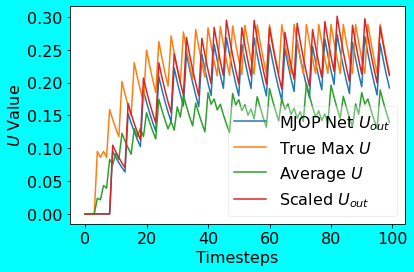

In [12]:
plt.figure(facecolor="#00FFFF")
plt.plot(loihi_sim1.data[net1_probe], label="MJOP Net $U_{out}$")
plt.plot(ngo_sim_max.data[otpt_probe_max], label="True Max $U$")
plt.plot(ngo_sim_avg.data[otpt_probe_avg], label="Average $U$")
plt.plot(loihi_sim2.data[net2_probe], label="Scaled $U_{out}$")
plt.xlabel("Timesteps", fontsize=FONTSIZE)
plt.ylabel("$U$ Value", fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.legend(framealpha=0.325, fontsize=FONTSIZE)
plt.savefig("max_jop_poc", dpi=450, bbox_inches = "tight")

# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

# AVAM Net Proof Of Concept

## Execute AVAM Net with $radius=0.25$

In [13]:
net4 = get_loihi_adapted_avam_net_for_2x2_max_pooling(
    radius=0.25, max_rate=500, synapse=0.005)
with net4:
  inpt = nengo.Node(output = lambda t: [1.0 if int(t*1000)%P1 == 0 else 0,
                                        1.0 if int(t*1000)%P2 == 0 else 0,
                                        1.0 if int(t*1000)%P3 == 0 else 0,
                                        1.0 if int(t*1000)%P4 == 0 else 0])
  ens4 = nengo.Ensemble(
      n_neurons=1, dimensions=1, radius=1, intercepts=[0], max_rates=[250],
      neuron_type=nengo_loihi.neurons.LoihiSpikingRectifiedLinear(
          amplitude=1/1000)
      )
  nengo.Connection(inpt, net4.inputs, synapse=0.005)
  nengo.Connection(net4.otp_node, ens4.neurons, synapse=None)
  # No Synpase since the input is already synapsed.
  max_otpt_4 = nengo.Probe(net4.otp_node, synapse=None) 

with nengo_loihi.Simulator(net4) as loihi_sim_4:
  loihi_sim_4.run(0.1)

INFO:DRV:  SLURM is being run in background


/homes/rgaurav/nengo-loihi/nengo_loihi/passthrough.py:118: UserWarning: Combining two Lowpass synapses, this may change the behaviour of the network (set `remove_passthrough=False` to avoid this).
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/block.py:214: UserWarning: tau_s is currently 0.005, which is smaller than 0.01. Overwriting tau_s with 0.01.
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/block.py:208: UserWarning: tau_s is already set to 0.01, which is larger than 0.005. Using 0.01.
  warnings.warn(


INFO:DRV:  Connecting to 10.212.98.106:44381
INFO:DRV:      Host server up..............Done 0.15s
INFO:DRV:      Encoding axons/synapses.....Done 3.42ms
INFO:DRV:      Compiling Embedded snips....Done 0.19s
INFO:DRV:      Compiling Host snips........Done 0.54s
INFO:DRV:      Compiling MPDS Registers....Done 0.36ms
INFO:HST:  Args chip=0 cpu=0 /homes/rgaurav/nxsdk_1_nengo_loihi/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1653251946.098491/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.65s
INFO:DRV:      Encoding probes.............Done 0.46ms
INFO:DRV:      Transferring probes.........Done 2.31ms
INFO:DRV:      Configuring registers.......Done 6.29ms
INFO:DRV:      Transferring spikes.........Done 0.25ms
INFO:HST:  [Host] Listening for client
INFO:HST:  [Host] Connected to client
INFO:HST:  chip=0 cpu=0 time 100
INFO:HST:  chip=0 cpu=0 Waited to exit (nonsense sum -13580)
INFO:DRV:      Executi

## Execute AVAM Net with $radius=0.30$

In [14]:
net5 = get_loihi_adapted_avam_net_for_2x2_max_pooling(
    radius=0.30, max_rate=500, synapse=0.005)
with net5:
  inpt = nengo.Node(output = lambda t: [1.0 if int(t*1000)%P1 == 0 else 0,
                                        1.0 if int(t*1000)%P2 == 0 else 0,
                                        1.0 if int(t*1000)%P3 == 0 else 0,
                                        1.0 if int(t*1000)%P4 == 0 else 0])
  ens5 = nengo.Ensemble(
      n_neurons=1, dimensions=1, radius=1, intercepts=[0], max_rates=[250],
      neuron_type=nengo_loihi.neurons.LoihiSpikingRectifiedLinear(
          amplitude=1/1000)
      )
  nengo.Connection(inpt, net5.inputs, synapse=0.005)
  nengo.Connection(net5.otp_node, ens5.neurons, synapse=None)
  # No Synpase since the input is already synapsed.
  max_otpt_5 = nengo.Probe(net5.otp_node, synapse=None) 

with nengo_loihi.Simulator(net5) as loihi_sim_5:
  loihi_sim_5.run(0.1)

INFO:DRV:  SLURM is being run in background


/homes/rgaurav/nengo-loihi/nengo_loihi/passthrough.py:118: UserWarning: Combining two Lowpass synapses, this may change the behaviour of the network (set `remove_passthrough=False` to avoid this).
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/block.py:208: UserWarning: tau_s is already set to 0.01, which is larger than 0.005. Using 0.01.
  warnings.warn(


INFO:DRV:  Connecting to 10.212.98.106:46075
INFO:DRV:      Host server up..............Done 0.15s
INFO:DRV:      Encoding axons/synapses.....Done 3.11ms
INFO:DRV:      Compiling Embedded snips....Done 0.25s
INFO:DRV:      Compiling Host snips........Done 0.52s
INFO:DRV:      Compiling MPDS Registers....Done 0.58ms
INFO:HST:  Args chip=0 cpu=0 /homes/rgaurav/nxsdk_1_nengo_loihi/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1653251948.6433246/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.65s
INFO:DRV:      Encoding probes.............Done 0.41ms
INFO:DRV:      Transferring probes.........Done 2.19ms
INFO:DRV:      Configuring registers.......Done 0.01s
INFO:DRV:      Transferring spikes.........Done 1.10ms
INFO:HST:  [Host] Listening for client
INFO:HST:  [Host] Connected to client
INFO:HST:  chip=0 cpu=0 time 100
INFO:HST:  chip=0 cpu=0 Waited to exit (nonsense sum -13580)
INFO:DRV:      Executi

## Execute AVAM Net with $radius=0.20$

In [15]:
net6 = get_loihi_adapted_avam_net_for_2x2_max_pooling(
    radius=0.20, max_rate=500, synapse=0.005)
with net6:
  inpt = nengo.Node(output = lambda t: [1.0 if int(t*1000)%P1 == 0 else 0,
                                        1.0 if int(t*1000)%P2 == 0 else 0,
                                        1.0 if int(t*1000)%P3 == 0 else 0,
                                        1.0 if int(t*1000)%P4 == 0 else 0])
  ens6 = nengo.Ensemble(
      n_neurons=1, dimensions=1, radius=1, intercepts=[0], max_rates=[250],
      neuron_type=nengo_loihi.neurons.LoihiSpikingRectifiedLinear(
          amplitude=1/1000)
      )
  nengo.Connection(inpt, net6.inputs, synapse=0.005)
  nengo.Connection(net6.otp_node, ens6.neurons, synapse=None)
  # No Synpase since the input is already synapsed.
  max_otpt_6 = nengo.Probe(net6.otp_node, synapse=None) 

with nengo_loihi.Simulator(net6) as loihi_sim_6:
  loihi_sim_6.run(0.1)

INFO:DRV:  SLURM is being run in background


/homes/rgaurav/nengo-loihi/nengo_loihi/passthrough.py:118: UserWarning: Combining two Lowpass synapses, this may change the behaviour of the network (set `remove_passthrough=False` to avoid this).
  warnings.warn(
/homes/rgaurav/nengo-loihi/nengo_loihi/block.py:208: UserWarning: tau_s is already set to 0.01, which is larger than 0.005. Using 0.01.
  warnings.warn(


INFO:DRV:  Connecting to 10.212.98.106:44763
INFO:DRV:      Host server up..............Done 0.15s
INFO:DRV:      Encoding axons/synapses.....Done 3.75ms
INFO:DRV:      Compiling Embedded snips....Done 0.27s
INFO:DRV:      Compiling Host snips........Done 0.59s
INFO:DRV:      Compiling MPDS Registers....Done 0.59ms
INFO:HST:  Args chip=0 cpu=0 /homes/rgaurav/nxsdk_1_nengo_loihi/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1653251951.3650353/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.65s
INFO:DRV:      Encoding probes.............Done 0.38ms
INFO:DRV:      Transferring probes.........Done 2.08ms
INFO:DRV:      Configuring registers.......Done 0.01s
INFO:DRV:      Transferring spikes.........Done 0.35ms
INFO:HST:  [Host] Listening for client
INFO:HST:  [Host] Connected to client
INFO:HST:  chip=0 cpu=0 time 100
INFO:HST:  chip=0 cpu=0 Waited to exit (nonsense sum -13580)
INFO:DRV:      Executi

## Compute True_Max $U$

In [16]:
with nengo.Network() as net_max:
  inpt_max = nengo.Node(output = lambda t: [1.0 if int(t*1000)%P1 == 0 else 0,
                                        1.0 if int(t*1000)%P2 == 0 else 0,
                                        1.0 if int(t*1000)%P3 == 0 else 0,
                                        1.0 if int(t*1000)%P4 == 0 else 0])
  # Compute max(U_1, U_2, U_3, U_4)
  otpt_max = nengo.Node(output=lambda t, x: max(x), size_in=4) 
  nengo.Connection(inpt_max, otpt_max, synapse=0.01)
  otpt_probe_max = nengo.Probe(otpt_max, synapse=None)
  
with nengo.Simulator(net_max) as ngo_sim_max:
  ngo_sim_max.run(0.1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

## Compute Average $U$

In [17]:
with nengo.Network() as net_avg:
  inpt_avg = nengo.Node(output = lambda t: [1.0 if int(t*1000)%P1 == 0 else 0,
                                        1.0 if int(t*1000)%P2 == 0 else 0,
                                        1.0 if int(t*1000)%P3 == 0 else 0,
                                        1.0 if int(t*1000)%P4 == 0 else 0])
  # Compute mean(U_1, U_2, U_3, U_4)
  otpt_avg = nengo.Node(output=lambda t, x: np.mean(x), size_in=4)
  nengo.Connection(inpt_avg, otpt_avg, synapse=0.01)
  otpt_probe_avg = nengo.Probe(otpt_avg, synapse=None)
  
with nengo.Simulator(net_avg) as ngo_sim_avg:
  ngo_sim_avg.run(0.1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

## Plot the results

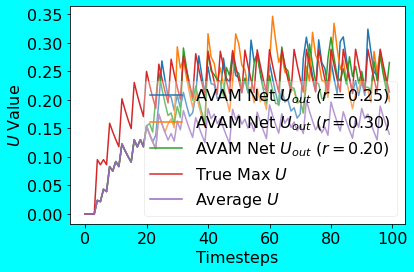

In [18]:
plt.figure(facecolor="#00FFFF")
plt.plot(loihi_sim_4.data[max_otpt_4], label="AVAM Net $U_{out}$ ($r=0.25$)")
plt.plot(loihi_sim_5.data[max_otpt_5], label="AVAM Net $U_{out}$ ($r=0.30$)")
plt.plot(loihi_sim_6.data[max_otpt_6], label="AVAM Net $U_{out}$ ($r=0.20$)")
plt.plot(ngo_sim_max.data[otpt_probe_max], label="True Max $U$")
plt.plot(ngo_sim_avg.data[otpt_probe_avg], label="Average $U$")
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.xlabel("Timesteps", fontsize=FONTSIZE)
plt.ylabel("$U$ Value", fontsize=FONTSIZE)
plt.legend(framealpha=0.325, fontsize=FONTSIZE)
plt.savefig("avam_net_poc", dpi=450, bbox_inches="tight")

# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX